<a href="https://colab.research.google.com/github/moonjune/test-repo/blob/master/kaggle_predictFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# kaggle_Predint_Future_Sales
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"junemhj09","key":"8addf4c6e59737f1a2948f9fe95488aa"}'}

In [2]:
import os
os.chdir('/content')
!ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
import os
os.mkdir('/content/predFS/')
os.chdir('/content/predFS/')

In [5]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 51.0MB/s]
  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.49MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.49MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 65.4MB/s]
 68% 9.00M/13.3M [00:00<00:00, 34.9MB/s]
100% 13.3M/13.3M [00:00<00:00, 44.2MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 146MB/s]


In [6]:
os.chdir('/content/predFS/')
!ls

item_categories.csv  sales_train.csv.zip	shops.csv
items.csv.zip	     sample_submission.csv.zip	test.csv.zip


In [0]:
os.mkdir('/content/predFS/input')
!mv item_categories.csv /content/predFS/input
!mv sales_train.csv.zip /content/predFS/input
!mv shops.csv /content/predFS/input
!mv items.csv.zip /content/predFS/input
!mv sample_submission.csv.zip /content/predFS/input
!mv test.csv.zip /content/predFS/input

In [8]:
os.chdir('/content/predFS/input')
!unzip sales_train.csv.zip 
!unzip items.csv.zip
!unzip sample_submission.csv.zip
!unzip test.csv.zip


Archive:  sales_train.csv.zip
  inflating: sales_train.csv         
Archive:  items.csv.zip
  inflating: items.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                


In [9]:
#https://www.kaggle.com/dlarionov/feature-engineering-xgboost

# feature engineering
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [0]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')

**Data Field**

**ID** - an Id that represents a (Shop, Item) tuple within the test set

**shop_id** - unique identifier of a shop

**item_id** - unique identifier of a product

**item_category_id** - unique identifier of item category

**item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure

**item_price** - current price of an item

**date** - date in format dd/mm/yyyy

**date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

**item_name** - name of item

**shop_name** - name of shop

**item_category_name** - name of item category

In [20]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


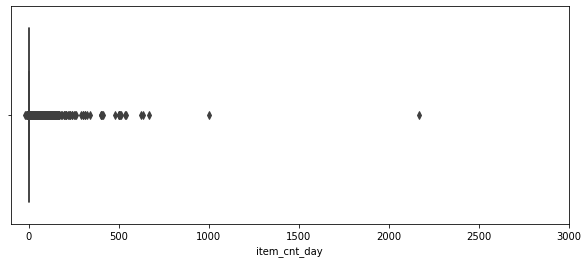

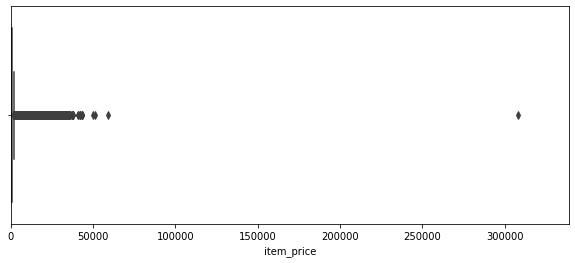

In [21]:
# outlier 찾기
plt.figure(figsize=(10,4)) # 그래프 판 사이즈
plt.xlim(-100, 3000) # x 좌표 설정
sns.boxplot(x=train.item_cnt_day) # 어떤 샵의 어떤 제품의 어떤 날짜 1일 판매량 박스 플롯으로

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1) # x 좌표 설정, 가격 최소값과 최대값을 직접 입력
sns.boxplot(x=train.item_price) # 제품 가격 박스 플롯

In [0]:
#outlier 제거
train = train[train.item_price<100000]  # 가격 100000 미만
train = train[train.item_cnt_day<1001]  # 하루 판매량 1000 이하

In [0]:
# 결측값 채우기
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
# 가격 외 위 조건의 항목 중 가격이 음의 값이 존재하며, 이를 같은 조건을 가진 다른 케이스들의 중앙값(median)으로 채움
train.loc[train.item_price<0, 'item_price'] = median 
# loc 다음은 행 값, 열 값을 줄 수 있음. 이 케이스의 경우 가격이 음인 케이스는 하나이므로 행조건에 별다른 조건을 걸지 않음

In [52]:
cats[:20]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [0]:
# 같은 가게를 다르게 입력한 케이스 통합, 단순 데이터 중복이 아닌 내용적 중복을 잡은 것이지만 그냥 스킬적으로만 알자
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [0]:
# # 신규 특징(도시명, 서브카테고리 명) 생성
# # 작성자는 가게앞 명칭이 도시명으로 되어 있다는 사실에 착안하여 도시명 생성
# shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
# #샵 이름의 도시명 정제
# shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) 
# # shop_name을 ' '으로 스플릿하여 ['도시이름', '샵이름']의 pd.Series가 나오며, map(lambda)의 x는 map앞을 받아 함수처리
# shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
# # 데이터 정제로 보임(특수문자 제거)
# shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# # sklearn의 함수로 괄호안 이터레이션에 고유값 별 라벨을 만들어주고 해당 값에 따라 라벨을 붙여줌
# shops = shops[['shop_id','city_code']]
# # shops 테이블 간소화, 최종적으로 가게 id와 도시이름 code만 남김
# # 가게명-도시명 관계 확인 -> 앞부분을 이용한 도시명 추출 -> 도시명 정제 -> 도시명 코드화 -> shop_id, city_code로 정리

# # 상위 카테고리(제품 종류)와 하위 카테고리(브랜드? 종류) 구분
# cats['split'] = cats['item_category_name'].str.split('-') # -로 연결된 두 개를 분리하여 DF로 남김
# cats['type'] = cats['split'].map(lambda x: x[0].strip()) # 제품 유형을 type으로 
# cats['type_code'] = LabelEncoder().fit_transform(cats['type']) # 제품 유형 라벨 붙이기
# # if subtype is nan then type
# cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip()) 
# cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
# cats = cats[['item_category_id','type_code', 'subtype_code']]

# items.drop(['item_name'], axis=1, inplace=True)

In [0]:
# shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
# #샵 이름의 도시명 정제
# shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) 
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

In [53]:
shops

,shop_name,shop_id,city,city_code
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск,0
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск,0
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,4
6,"Воронеж (Плехановская, 13)",6,Воронеж,5
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,5
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,5
9,Выездная Торговля,9,Выездная,6
